In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss", range=[0,0.001]):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(range[0], range[1])
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def score_pred(model, X, text):
    pred = model.predict(X)
    score = np.sqrt(mean_squared_error(pred,X))
    print(f"{text} (RMSE): {score}")
    
def standardization_by_duration(matrix, duration_fraction):
    # duration = 10s 
    # duration fraction = 0.2
    # sample time = duration * param time
    # bits per second = 10 bps
    # In 10s there are 100bps

    # 20%´s duration is 2s, in that time there would 2bps
    # To standarize the values in relation to the duration
    # the equation should be: (bits per second)bps * (sample time)s /(duration)s

    duration = matrix[:,0] 
    sample_time = duration * duration_fraction
    standarized_matrix = (matrix * sample_time[:,None]) / duration[:,None]
    
    standarized_matrix[:,0]  = sample_time
    return standarized_matrix

In [35]:
mainpath="../NSL-KDD/"
transformed_datasets_folder = "transformed_datasets/"
tuned_complete_traffic = "complete_trafic_retocado.csv"
file_anomaly_traffic = "anomaly_traffic.csv"

csv_tuned_traffic_path = mainpath + transformed_datasets_folder + tuned_complete_traffic
csv_anomaly_traffic_path = mainpath + transformed_datasets_folder + file_anomaly_traffic

In [36]:
df_tuned_traffic = pd.read_csv(csv_tuned_traffic_path)

df_tuned_traffic.drop('Unnamed: 0',axis=1,inplace=True)

label_grouped = df_tuned_traffic.groupby(['class'])

print(label_grouped['class'].value_counts())

df_anomaly_traffic = label_grouped.get_group(1)
df_normal_traffic = label_grouped.get_group(0)

print(f"Normal count: {len(df_normal_traffic)}")
print(f"Attack count: {len(df_anomaly_traffic)}")

class  class
0      0        77054
1      1        71463
Name: class, dtype: int64
Normal count: 77054
Attack count: 71463


In [37]:
df_normal_traffic.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,5607.0,2,44,9,147.0,105.0,0,0.0,0.0,0.0,...,1.0,0.00,0.85,1.00,0.0,0.00,0.0,0.00,0.00,0
1,507.0,1,60,9,437.0,14421.0,0,0.0,0.0,0.0,...,25.0,0.10,0.05,0.00,0.0,0.53,0.0,0.02,0.16,0
2,1.0,2,49,9,105.0,147.0,0,0.0,0.0,0.0,...,5.0,0.12,0.05,0.05,0.0,0.00,0.0,0.00,0.00,0
3,2.0,1,54,9,1591.0,372.0,0,0.0,0.0,0.0,...,147.0,0.81,0.02,0.01,0.0,0.00,0.0,0.00,0.00,0
4,9052.0,2,44,9,146.0,105.0,0,0.0,0.0,0.0,...,2.0,0.01,0.66,0.99,0.0,0.00,0.0,0.00,0.00,0


In [38]:
df_anomaly_traffic.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
8,25950.0,1,49,4,1.0,0.0,0,0.0,0.0,0.0,...,2.0,0.01,0.69,1.0,0.00,0.0,0.0,1.0,1.0,1
12,9015.0,1,44,4,1.0,0.0,0,0.0,0.0,0.0,...,2.0,0.01,0.74,1.0,0.00,0.0,0.0,1.0,1.0,1
15,15159.0,1,19,9,350.0,1185.0,0,0.0,0.0,6.0,...,142.0,0.56,0.02,0.0,0.00,0.0,0.0,0.0,0.0,1
17,4.0,1,20,9,832.0,0.0,0,0.0,0.0,0.0,...,28.0,1.00,0.00,1.0,0.18,0.0,0.0,0.0,0.0,1
20,9235.0,1,44,4,1.0,0.0,0,0.0,0.0,0.0,...,2.0,0.01,0.74,1.0,0.00,0.0,0.0,1.0,1.0,1


In [39]:
np_array = df_normal_traffic.to_numpy()
class_label = np_array[:, -1] # for last column
data = np_array[:, :-1] # for all but last column

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data, class_label, test_size=0.1, random_state=42)
print(len(data))
print(len(X_train))

77054
69348


In [41]:
# 0,9*0,23 = 0,207
X_train, X_val, _, _  = train_test_split(X_train, y_train, test_size=0.23, random_state=42)
print(len(X_val))
print(len(X_train))

15951
53397


In [42]:
X_train = preprocessing.normalize(X_train,norm='l2')
X_test = preprocessing.normalize(X_test,norm='l2')
X_val = preprocessing.normalize(X_val,norm='l2')

In [43]:
# Parametros de la red
batch_size = 64
epochs = 50
encoder_layer_1 = 25
encoder_layer_2 = 8
latent_layer = 3
decoder_layer_1 = encoder_layer_1
decoder_layer_2 = encoder_layer_2
data_dimention = data.shape[1]
activation_type = "relu"
kernel_init = "glorot_uniform"
patience = 5
regularization_parameter = 0.0001
dropout_parameter = 0.4

In [44]:
model = Sequential([
    Dense(encoder_layer_1, input_dim=data_dimention, activation=activation_type),
    Dense(latent_layer, activation=activation_type),
    Dense(decoder_layer_1, activation=activation_type),
    Dense(data_dimention)
])

In [45]:
model.compile(loss='mean_squared_error', optimizer="adam")

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [47]:
history = model.fit(X_train, X_train, 
              epochs=epochs, 
              validation_data=(X_val, X_val),
              batch_size=batch_size,
              callbacks=[es]
          )

Epoch 1/50
835/835 [==============================] - 3s 4ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 2/50
835/835 [==============================] - 3s 4ms/step - loss: 0.0011 - val_loss: 8.5912e-04
Epoch 3/50
835/835 [==============================] - 4s 5ms/step - loss: 7.7345e-04 - val_loss: 6.7570e-04
Epoch 4/50
835/835 [==============================] - 4s 5ms/step - loss: 6.1934e-04 - val_loss: 5.5113e-04
Epoch 5/50
835/835 [==============================] - 4s 5ms/step - loss: 4.9865e-04 - val_loss: 4.3191e-04
Epoch 6/50
835/835 [==============================] - 3s 3ms/step - loss: 4.0282e-04 - val_loss: 3.5648e-04
Epoch 7/50
835/835 [==============================] - 3s 3ms/step - loss: 3.4023e-04 - val_loss: 3.0004e-04
Epoch 8/50
835/835 [==============================] - 3s 3ms/step - loss: 2.9075e-04 - val_loss: 2.6064e-04
Epoch 9/50
835/835 [==============================] - 3s 3ms/step - loss: 2.5879e-04 - val_loss: 2.3620e-04
Epoch 10/50
835/835 [===================

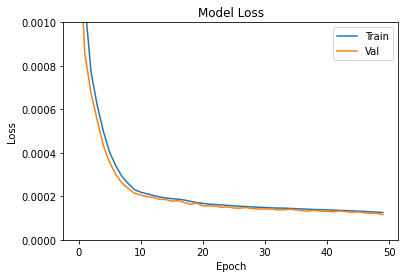

In [48]:
plot_loss(history)

In [49]:
np_anomaly_array = df_anomaly_traffic.to_numpy()
X_anomaly = np_anomaly_array[:, :-1] # for all but last column
X_anomaly = preprocessing.normalize(X_anomaly,norm='l2')

In [50]:
score_pred(model, X_test, "Out of Sample Normal Score")
score_pred(model, X_train, "Insample Normal Score")
score_pred(model, X_anomaly, "Attack Underway Score")

Out of Sample Normal Score (RMSE): 0.011587917865947038
Insample Normal Score (RMSE): 0.010974613430614871
Attack Underway Score (RMSE): 0.05016954473705368


In [57]:
score_pred(model, standardization_by_duration(X_test, 0.8), "Out of Sample Normal Score")
score_pred(model, standardization_by_duration(X_train, 0.8), "Insample Normal Score")
score_pred(model, standardization_by_duration(X_anomaly, 0.8), "Attack Underway Score")

Out of Sample Normal Score (RMSE): 0.037021093578620524
Insample Normal Score (RMSE): 0.036832562005514366
Attack Underway Score (RMSE): 0.04656698066344003
